### Очистка и подготовка данных

Данные не всегда представляют собой идеально организованный набор наблюдений без каких-либо пропусков или аномалий Обычно данные содержат в себе кучу мусора, который необходимо почистить, да и вообще сами данные порой лучше воспринимать критически, для того чтобы затем привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.



Источники недостающих ценностей

Прежде чем мы углубимся в код, важно понять источники недостающих данных. Вот несколько типичных причин отсутствия данных:
<ol>
    <li> Пользователь забыл заполнить поле.</li>

<li> Данные были потеряны при переносе вручную из устаревшей базы данных.</li>

<li> Произошла ошибка программирования.</li>

<li> Пользователи решили не заполнять поле, связанное с их мнением о том, как результаты будут использоваться или интерпретироваться.</li>
</ol>

### 2 главные проблемы при подготовке данных: пропущенные значения и неправильная типизация


In [1]:
import pandas as pd
 
df = pd.read_csv('https://raw.githubusercontent.com/alnagaev/landing/master/train.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.shape

(891, 12)

In [ ]:
df.info()
#показывает в том числе сколько пропущенных значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


To do list:

1) Возраст

2) Каюта

Очистка данных порой предполагает избавление от неиспользуемых сущностей/столбцов

In [ ]:
# Удаляем столбцы, в которых нет ценной для нас информации
df.drop(['Ticket', 'Cabin'], axis = 1, inplace=True)

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [ ]:
# Округляем стоимость билета до двух знаков после запятой
df.Fare = round(df.Fare, 2)


 Посчитаем пропущенные значения

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Nan = not a number 

### Пропущенные значения можно удалить, но скорее так делать не следует

In [ ]:
df[df['Age'].isna()]['Pclass'].value_counts(normalize=True)
#можно настраивать и изменять способ удаления данных, например с помощью параметра thresh=2, который оставит строки с боллее чем 2 непустыми значениями

3    0.768362
1    0.169492
2    0.062147
Name: Pclass, dtype: float64

### Пропущенные значения можно заменять на что-то другое

In [ ]:
#Способ 1: Константа 
df['Age'].median()

28.0

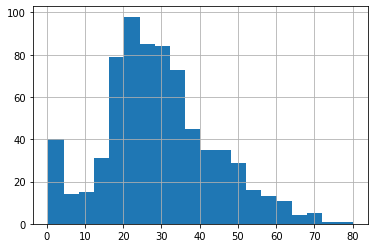

In [ ]:
df['Age'].hist(bins=20)

In [ ]:
# Способ 2: медиана
print(df['Age'].median())
df['Age'].fillna(df['Age'].median())

28.0


0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [ ]:
# Способ 2: Cредние арифметические в зависимости от класса каюты
age_1 = df[df['Pclass'] == 1]['Age'].mean()
age_2 = df[df['Pclass'] == 2]['Age'].mean()
age_3 = df[df['Pclass'] == 3]['Age'].mean()

In [ ]:
def fill_age(row):
    if pd.isnull(row['Age']):
        if row['Pclass'] == 1:
            return age_1
        
        if row['Pclass'] == 2:
            return age_2
        
        if row['Pclass'] == 3:
            return age_3
        
    return row['Age']

In [ ]:
df.apply(fill_age, axis=1)

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    25.14062
889    26.00000
890    32.00000
Length: 891, dtype: float64

https://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.DataFrame.interpolate.html

https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

## Метод GROUP BY (Привет SQL)

Принцип действия **groupby**
![](https://i.stack.imgur.com/sgCn1.jpg)

- Разделение данных по группам по определенному критерию

- Применение к каждой группе определенной функции

- Сложение результатов в единую структуру

In [2]:
df.groupby('Pclass')['Age'].agg('mean')

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [ ]:
df.groupby('Pclass')['Age'].apply(lambda x:x.fillna(x.mean()))

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    25.14062
889    26.00000
890    32.00000
Name: Age, Length: 891, dtype: float64

На всякий случай проверяем равны ли полученные объекты

In [ ]:
(df.apply(fill_age, axis = 1)).equals(df.groupby('Pclass')['Age'].apply(lambda x:x.fillna(x.mean())))

True

In [ ]:
df.groupby('Pclass')['Age'].apply(lambda x:x.fillna(x.mean()))

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    25.14062
889    26.00000
890    32.00000
Name: Age, Length: 891, dtype: float64

In [ ]:
df.groupby('Pclass')['Age'].apply(lambda x:x.fillna(x.mean()))

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    25.14062
889    26.00000
890    32.00000
Name: Age, Length: 891, dtype: float64

In [ ]:
%%timeit
df.groupby('Pclass')['Survived'].agg(sum)

1000 loops, best of 3: 915 µs per loop


In [ ]:
df.groupby(['Pclass', 'Sex'])['Age'].agg('mean')


Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

### Создаем новый столбец с информацией о том, был ли пассажир на борту один или с родственниками
Столбец должен содержать значение "alone", если он был на борту один (без супруга/супруги, братьев, сестер, детей и родителей) и значение "not alone", если пассажир путешествовал с кем-то из родственников

sibsp Number of Siblings/Spouses Aboard

parch Number of Parents/Children Aboard 

In [ ]:
# Способ 1: с помощью именной функции и apply
def alone_check(row):
    if row['SibSp'] or row['Parch']:
        return 0
    return 1
    
df['Alone'] = df.apply(alone_check, axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [ ]:
if 1:
  print('f')
if 0:
  print('g')

f


In [ ]:
df.groupby(['Pclass', 'Sex', 'Alone'])['Survived'].agg('sum')


Pclass  Sex     Alone
1       female  0        58
                1        33
        male    0        20
                1        25
2       female  0        41
                1        29
        male    0        10
                1         7
3       female  0        35
                1        37
        male    0        15
                1        32
Name: Survived, dtype: int64

In [ ]:
# Способ 2: с помощью lambda-функции
try:
    df.drop('Alone', axis=1, inplace = True)
except KeyError:
    print('already dropped')


In [ ]:
df['Alone'] = df.apply(lambda x: 1 if x['SibSp'] or x['Parch'] else 0, axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


In [ ]:
df['Rich'] = df.apply(lambda x: 1 if x['Pclass'] == 1 and x['Fare'] >100 else 0, axis = 1) 
len(df[df['Rich']==1])

53

In [ ]:
len(df[(df['Rich'] == 1) & (df['Survived'] == 1)])

39

In [ ]:
df.Fare.max()

512.3292

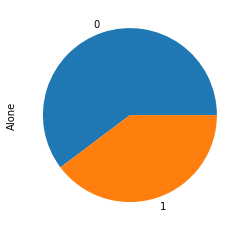

In [ ]:
df['Alone'].value_counts().plot(kind='pie')

### Строим сводную таблицу

In [ ]:
df.groupby('Sex')[['Survived']].mean() #начинаем с простого

,Survived
Sex,
female,0.742038
male,0.188908


Сразу же можно сделать вывод о том, что из каждых четырех женщин, находившихся на борту, выжили три, в то время как из каждых пяти мужчин выжил только один!

Это интересная информация, но мы можем пойти дальше и выяснить взаимосвязь между показателем выживаемости и двумя другими параметрами, такими как пол и, например, класс. Используя терминологию GroupBy, мы могли бы сформулировать последовательность наших действий следующим образом: группируем по (group by) классу и полу, отбираем (select) выживших, применяем (apply) агрегацию по среднему, объединяем (combine) результирующие группы и преобразуем (unstack) иерархический индекс, чтобы раскрыть скрытую многомерность. Выразим это в коде:

In [ ]:
df.groupby(['Sex', 'Pclass'])['Survived'].agg('mean').unstack()

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Теперь мы имеем четкое представление о том, как пол и класс повлияли на выживаемость, но код становится немного громоздким. Хотя каждый шаг этой последовательности вполне понятен в свете рассмотренных выше инструментов, тем не менее длинную строку кода достаточно трудно читать и использовать. Подобные операции широко распространены, в связи с чем библиотека Pandas имеет в своем составе специальный метод pivot_table, лаконично реализующий данный тип многомерной агрегации.

In [ ]:
df.pivot_table(values='Survived', index='Sex', columns='Pclass', aggfunc='mean', margins=True)
df.pivot_table()

Pclass,1,2,3,All
Sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


In [ ]:
age = pd.cut(df['Age'], [0, 18, 80])
df.pivot_table('Survived', ['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

### Join'ы

In [ ]:
import pandas as pd
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
'group': ['Accounting', 'Engineering', 'Engineering',
'HR']})

df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
'hire_date': [2004, 2008, 2012, 2014]})
print(df1); print(df2)
 

  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014


In [ ]:
df3 = pd.merge(df1, df2)
df3
#подробнее https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


### Дополнительные приемы работы с числами

In [ ]:
new_df = pd.DataFrame({'col1': [1,2,3,4,5], 'col2': '2,5 4,5 3.3 1,5 2,9'.split()})



In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   col1    5 non-null      int64 
 1   col2    5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
new_df['col2'] = new_df['col2'].apply(lambda x: float(x.replace(',', '.')))
new_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    5 non-null      int64  
 1   col2    5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 208.0 bytes


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    5 non-null      int64  
 1   col2    5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 208.0 bytes


In [ ]:
new_df['col2'] = pd.to_numeric(new_df['col2'])

In [ ]:
new_df['col2'] = new_df['col2'].astype('float64')

In [ ]:
new_df['col2'] = new_df['col2'].apply(lambda x: float(x))



#### Если нужно заменить сразу много столбцов

In [ ]:
strNum = pd.DataFrame({'col1': '56,5 2,5 3.3 1,5 2,9'.split(), 'col2': '2,5 4,5 3.3 1,5 2,9'.split(), 
                       'col3': '7,6 4,5 3.3 7,5 1,9'.split()})
strNum

,col1,col2,col3
0,"56,5","2,5","7,6"
1,"2,5","4,5","4,5"
2,3.3,3.3,3.3
3,"1,5","1,5","7,5"
4,"2,9","2,9","1,9"


In [ ]:
list(strNum)

['col1', 'col2', 'col3']

In [ ]:
for i in list(strNum):
    strNum[i] = strNum[i].apply(lambda x: float(x.replace(',', '.')))



### Работа с датами

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2016-weather-data-seattle.csv')

df.head(10)

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC
0,1/1/1948,10,8.0,7.0
1,1/2/1948,6,4.0,3.0
2,1/3/1948,7,4.0,2.0
3,1/4/1948,7,4.0,2.0
4,1/5/1948,7,3.0,0.0
5,1/6/1948,9,7.0,5.0
6,1/7/1948,10,7.0,4.0
7,1/8/1948,8,5.0,2.0
8,1/9/1948,9,4.0,1.0
9,1/10/1948,6,4.0,2.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24381 entries, 0 to 24380
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               24381 non-null  object 
 1   Max_TemperatureC   24381 non-null  int64  
 2   Mean_TemperatureC  24376 non-null  float64
 3   Min_TemperatureC   24380 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 762.0+ KB


In [ ]:
df.isna().sum()

Date                 0
Max_TemperatureC     0
Mean_TemperatureC    5
Min_TemperatureC     1
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0       1948-01-01
1       1948-01-02
2       1948-01-03
3       1948-01-04
4       1948-01-05
           ...    
24376   2015-12-27
24377   2015-12-28
24378   2015-12-29
24379   2015-12-30
24380   2015-12-31
Name: Date, Length: 24381, dtype: datetime64[ns]

In [ ]:
df['Date'].dt.year

0        1948
1        1948
2        1948
3        1948
4        1948
         ... 
24376    2015
24377    2015
24378    2015
24379    2015
24380    2015
Name: Date, Length: 24381, dtype: int64

### Создание новых временнЫх признаков

In [ ]:
df['current_time'] = pd.to_datetime('today').strftime("%m/%d/%Y")



In [ ]:
df['current_time'] = pd.to_datetime(df['current_time'])

In [ ]:
df['timedelta'] = (df['current_time']-df['Date']).astype('timedelta64[Y]')
df

,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,current_time,timedelta
0,1948-01-01,10,8.0,7.0,2020-10-17,72.0
1,1948-01-02,6,4.0,3.0,2020-10-17,72.0
2,1948-01-03,7,4.0,2.0,2020-10-17,72.0
3,1948-01-04,7,4.0,2.0,2020-10-17,72.0
4,1948-01-05,7,3.0,0.0,2020-10-17,72.0
...,...,...,...,...,...,...
24376,2015-12-27,4,3.0,2.0,2020-10-17,4.0
24377,2015-12-28,5,3.0,2.0,2020-10-17,4.0
24378,2015-12-29,7,4.0,1.0,2020-10-17,4.0
24379,2015-12-30,6,2.0,-1.0,2020-10-17,4.0


### Удаление дупликатов

In [ ]:
data = {"Name": ["James", "Alice", "Phil", "James"],
"Age": [24, 28, 40, 24],
"Sex": ["Male", "Female", "Male", "Male"]}

df = pd.DataFrame(data)
df


,Name,Age,Sex
0,James,24,Male
1,Alice,28,Female
2,Phil,40,Male
3,James,24,Male


In [ ]:
df.drop_duplicates( )

,Name,Age,Sex
0,James,24,Male
1,Alice,28,Female
2,Phil,40,Male


### Строковые методы очистки данных

### Создание dummy переменных

In [7]:
import pandas as pd
 
df = pd.read_csv('https://raw.githubusercontent.com/alnagaev/landing/master/train.csv')

#Прием может пригодится при работе над одним из проектов курса и в реальной жизни
df['Embarked'].str.get_dummies()

df = pd.concat([df, df['Embarked'].str.get_dummies()], axis=1)
df.pop('Embarked')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,0,1


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/alnagaev/reni_land/master/test.csv')
df.head(10)

,id,Дата рождения,Вакансия,Технология,Локация,З/п в валюте найма
0,1,18.04.1994,Инженер-программист 2 категории,JS,Санкт-Петербург,"140 000,00 ₽"
1,2,27.03.1993,Разработчик информационных систем,.NET,Москва,"130 000,00 ₽"
2,3,24.11.1983,Java Developer,Java,Санкт-Петербург,"200 000,00 ₽"
3,4,09.06.1989,Архитектор ПО,Java,Москва,"250 000,00 ₽"
4,5,03.10.1978,QA Automation Engineer,QA,Санкт-Петербург,"172 413,00 ₽"
5,6,21.08.1973,Big Data Developer,Big Data,Санкт-Петербург,"280 000,00 ₽"
6,7,10.10.1991,JS Developer,JS,Москва,"129 000,00 ₽"
7,8,16.08.1982,Разработчик мобильных приложений,Android,Москва,"185 000,00 ₽"
8,9,16.05.1988,Инженер-программист 2 категории,.NET,Санкт-Петербург,"160 000,00 ₽"
9,10,01.12.1990,Java Engineer,Java,Краков; Польша,"9 500,00 zł"


In [ ]:
df[df['Вакансия'].str.contains('Java')]

,id,Дата рождения,Вакансия,Технология,Локация,З/п в валюте найма
2,3,24.11.1983,Java Developer,Java,Санкт-Петербург,"200 000,00 ₽"
9,10,01.12.1990,Java Engineer,Java,Краков; Польша,"9 500,00 zł"
12,13,04.11.1988,JavaScript Engineer,JavaScript,Краков; Польша,"10 500,00 zł"
15,16,30.08.1982,Java Developer,Java,Москва,"180 000,00 ₽"
27,28,09.10.1990,Java Developer,Java,Москва,"170 000,00 ₽"
30,31,09.02.1992,Senior Java developer,Java,Санкт-Петербург,"264 367,82 ₽"
32,33,26.09.1981,Java Developer,Java,Москва,"210 000,00 ₽"
37,38,03.04.1990,JavaScript Engineer,JavaScript,Краков; Польша,"13 000,00 zł"
45,46,25.10.1985,Senior Java developer,Java,Санкт-Петербург,"252 900,00 ₽"
49,50,09.02.1985,Java Developer,Java,Москва,"300 000,00 ₽"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  58 non-null     int64 
 1   Дата рождения       58 non-null     object
 2   Вакансия            58 non-null     object
 3   Технология          58 non-null     object
 4   Локация             58 non-null     object
 5   З/п в валюте найма  58 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.8+ KB


Создание новых признаков

In [ ]:
df['salary'] = df['З/п в валюте найма'].apply(lambda x: int(''.join([s for s in list(x) if s.isdigit()]))/100)
df['currency'] = df['З/п в валюте найма'].apply(lambda x: ''.join([s for s in list(x) if not s.isdigit()]).replace(',', ''))
df.head(10)

,id,Дата рождения,Вакансия,Технология,Локация,З/п в валюте найма,salary,currency
0,1,18.04.1994,Инженер-программист 2 категории,JS,Санкт-Петербург,"140 000,00 ₽",140000.0,₽
1,2,27.03.1993,Разработчик информационных систем,.NET,Москва,"130 000,00 ₽",130000.0,₽
2,3,24.11.1983,Java Developer,Java,Санкт-Петербург,"200 000,00 ₽",200000.0,₽
3,4,09.06.1989,Архитектор ПО,Java,Москва,"250 000,00 ₽",250000.0,₽
4,5,03.10.1978,QA Automation Engineer,QA,Санкт-Петербург,"172 413,00 ₽",172413.0,₽
5,6,21.08.1973,Big Data Developer,Big Data,Санкт-Петербург,"280 000,00 ₽",280000.0,₽
6,7,10.10.1991,JS Developer,JS,Москва,"129 000,00 ₽",129000.0,₽
7,8,16.08.1982,Разработчик мобильных приложений,Android,Москва,"185 000,00 ₽",185000.0,₽
8,9,16.05.1988,Инженер-программист 2 категории,.NET,Санкт-Петербург,"160 000,00 ₽",160000.0,₽
9,10,01.12.1990,Java Engineer,Java,Краков; Польша,"9 500,00 zł",9500.0,zł


**Приведем список технологий к единообразию на примере JS**

In [ ]:
df['Технология'] = df['Технология'].replace('JavaScript', 'JS')

In [ ]:
df[df["Технология"].isin(["JS", 'Java'])]

,id,Дата рождения,Вакансия,Технология,Локация,З/п в валюте найма,salary,currency
0,1,18.04.1994,Инженер-программист 2 категории,JS,Санкт-Петербург,"140 000,00 ₽",140000.00,₽
2,3,24.11.1983,Java Developer,Java,Санкт-Петербург,"200 000,00 ₽",200000.00,₽
3,4,09.06.1989,Архитектор ПО,Java,Москва,"250 000,00 ₽",250000.00,₽
6,7,10.10.1991,JS Developer,JS,Москва,"129 000,00 ₽",129000.00,₽
9,10,01.12.1990,Java Engineer,Java,Краков; Польша,"9 500,00 zł",9500.00,zł
10,11,04.02.1991,Инженер-программист,JS,Москва,"170 000,00 ₽",170000.00,₽
12,13,04.11.1988,JavaScript Engineer,JS,Краков; Польша,"10 500,00 zł",10500.00,zł
13,14,09.04.1990,Software Engineer,JS,Вроцлав; Польша,"9 500,00 zł",9500.00,zł
15,16,30.08.1982,Java Developer,Java,Москва,"180 000,00 ₽",180000.00,₽
17,18,28.08.1995,JS Developer,JS,Москва,"160 000,00 ₽",160000.00,₽


In [ ]:
df.query('Технология == "JS" | Технология == "Java"')

,id,Дата рождения,Вакансия,Технология,Локация,З/п в валюте найма,salary,currency
0,1,18.04.1994,Инженер-программист 2 категории,JS,Санкт-Петербург,"140 000,00 ₽",140000.00,₽
2,3,24.11.1983,Java Developer,Java,Санкт-Петербург,"200 000,00 ₽",200000.00,₽
3,4,09.06.1989,Архитектор ПО,Java,Москва,"250 000,00 ₽",250000.00,₽
6,7,10.10.1991,JS Developer,JS,Москва,"129 000,00 ₽",129000.00,₽
9,10,01.12.1990,Java Engineer,Java,Краков; Польша,"9 500,00 zł",9500.00,zł
10,11,04.02.1991,Инженер-программист,JS,Москва,"170 000,00 ₽",170000.00,₽
12,13,04.11.1988,JavaScript Engineer,JS,Краков; Польша,"10 500,00 zł",10500.00,zł
13,14,09.04.1990,Software Engineer,JS,Вроцлав; Польша,"9 500,00 zł",9500.00,zł
15,16,30.08.1982,Java Developer,Java,Москва,"180 000,00 ₽",180000.00,₽
17,18,28.08.1995,JS Developer,JS,Москва,"160 000,00 ₽",160000.00,₽


Метод **str.contains**

In [ ]:
df['Вакансия'].str.split(expand=True)



,0,1,2,3,4
0,Инженер-программист,2,категории,None,None
1,Разработчик,информационных,систем,None,None
2,Java,Developer,None,None,None
3,Архитектор,ПО,None,None,None
4,QA,Automation,Engineer,None,None
5,Big,Data,Developer,None,None
6,JS,Developer,None,None,None
7,Разработчик,мобильных,приложений,None,None
8,Инженер-программист,2,категории,None,None
9,Java,Engineer,None,None,None


### Спасибо за внимание! Буду рад ответить на ваши вопросы

Форма ОС
https://forms.gle/w6TjMeYPDYqQAFSJ8 